In [1]:
#!/bin/python3

In [2]:
import torch
import torch.nn.modules as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import pandas as pd

In [5]:
df  = pd.read_csv("FINAL_FROM_DF.csv")

In [6]:
df = df[df["SYMBOL"]=="ADANIPOWER"]
df.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
21,ADANIPOWER,EQ,27.10,28.45,26.75,28.25,28.35,27.10,12240267,3.401227e+08,2017-06-28,21224,INE814H01011
1763,ADANIPOWER,EQ,36.60,37.15,36.15,36.60,36.40,36.60,12486335,4.578317e+08,2017-11-28,23493,INE814H01011
3586,ADANIPOWER,EQ,38.60,39.20,38.30,38.60,38.60,38.70,3993530,1.544753e+08,2017-02-28,8772,INE814H01011
5313,ADANIPOWER,EQ,33.00,33.15,32.45,33.00,33.15,32.70,8986064,2.947097e+08,2017-04-28,10031,INE814H01011
7062,ADANIPOWER,EQ,39.75,41.10,39.10,40.30,40.35,39.55,17813256,7.180954e+08,2017-03-20,19740,INE814H01011


In [19]:
data = df.values.tolist()

n1 = int(len(data)*0.8)
n2 = int(len(data)*0.9)
train_data = data[:n1]
val_data =data[n1:n2]
test_data = data[n2:]
#len(train_data),len(val_data),len(test_data)
data

[['ADANIPOWER',
  'EQ',
  27.1,
  28.45,
  26.75,
  28.25,
  28.35,
  27.1,
  12240267,
  340122683.45,
  '2017-06-28',
  21224,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  36.6,
  37.15,
  36.15,
  36.6,
  36.4,
  36.6,
  12486335,
  457831717.5,
  '2017-11-28',
  23493,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  38.6,
  39.2,
  38.3,
  38.6,
  38.6,
  38.7,
  3993530,
  154475344.3,
  '2017-02-28',
  8772,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  33.0,
  33.15,
  32.45,
  33.0,
  33.15,
  32.7,
  8986064,
  294709667.1,
  '2017-04-28',
  10031,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  39.75,
  41.1,
  39.1,
  40.3,
  40.35,
  39.55,
  17813256,
  718095371.1,
  '2017-03-20',
  19740,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  33.8,
  35.1,
  33.5,
  34.75,
  34.75,
  34.35,
  20240104,
  696586041.25,
  '2017-01-23',
  26581,
  'INE814H01011'],
 ['ADANIPOWER',
  'EQ',
  30.95,
  31.05,
  30.15,
  30.25,
  30.2,
  30.85,
  5506721,
  167715525.75,
  '2017-05-12',
  8181,


In [12]:
def get_batch(batch_size,seq_len,split=None):
    data = torch.tensor(train_data) if split == None else torch.tensor(split)
    ix = range(0,len(data)-seq_len)
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:1+i+seq_len][-1] for i in ix])
    no_of_batch = int(len(x)/batch_size)
    x_batch = x[:no_of_batch*batch_size]
    y_batch = y[:no_of_batch*batch_size].view(-1,batch_size)
    x_batch = x_batch.view(no_of_batch,batch_size,seq_len)
    
    # Handle the remaining data (if any)
    leftover_x = x[no_of_batch * batch_size:]
    leftover_y = y[no_of_batch * batch_size:]

    if len(leftover_x) > 0:
        pad_length = batch_size - len(leftover_x)
        padding_x = torch.zeros((pad_length, seq_len))  # Padding with zeros
        padding_y = torch.zeros((pad_length,))  # Padding with zeros

        # Append padding to leftover data
        leftover_x = torch.cat([leftover_x, padding_x], dim=0)
        leftover_y = torch.cat([leftover_y, padding_y], dim=0)
        
        leftovers = (leftover_x,leftover_y)
        print(f"leftovers : {len(leftover_x)/batch_size}")
    
    return x_batch,y_batch.unsqueeze(2),(leftovers if len(leftover_x) else None)

In [13]:
class Scaling:
    def __init__(self,data=list):
        self.data = data
        self.min_value=min(data)
        self.max_value = max(data)
    def Normalization(self,denormalize=None,normalization=None):
        if denormalize ==None and normalization== None:
            normalized_data =[(i - self.min_value)/(self.max_value-self.min_value) for i in self.data]
            return normalized_data
        elif normalization != None:
            if isinstance(denormalize, (float, int)):
                return (normalization - self.min_value)/(self.max_value-self.min_value)
            normalized_data =[(i - self.min_value)/(self.max_value-self.min_value) for i in normalization]
            return normalized_data

        else:

            if isinstance(denormalize, (float, int)):
                return denormalize * (self.max_value - self.min_value) +self.min_value 
            denormalize_data = [i * (self.max_value - self.min_value) + self.min_value for i in denormalize]
            return denormalize_data

In [14]:
batch_size =5
seq_len =3
x_train,y_train,_= get_batch(batch_size,seq_len)

ValueError: too many dimensions 'str'

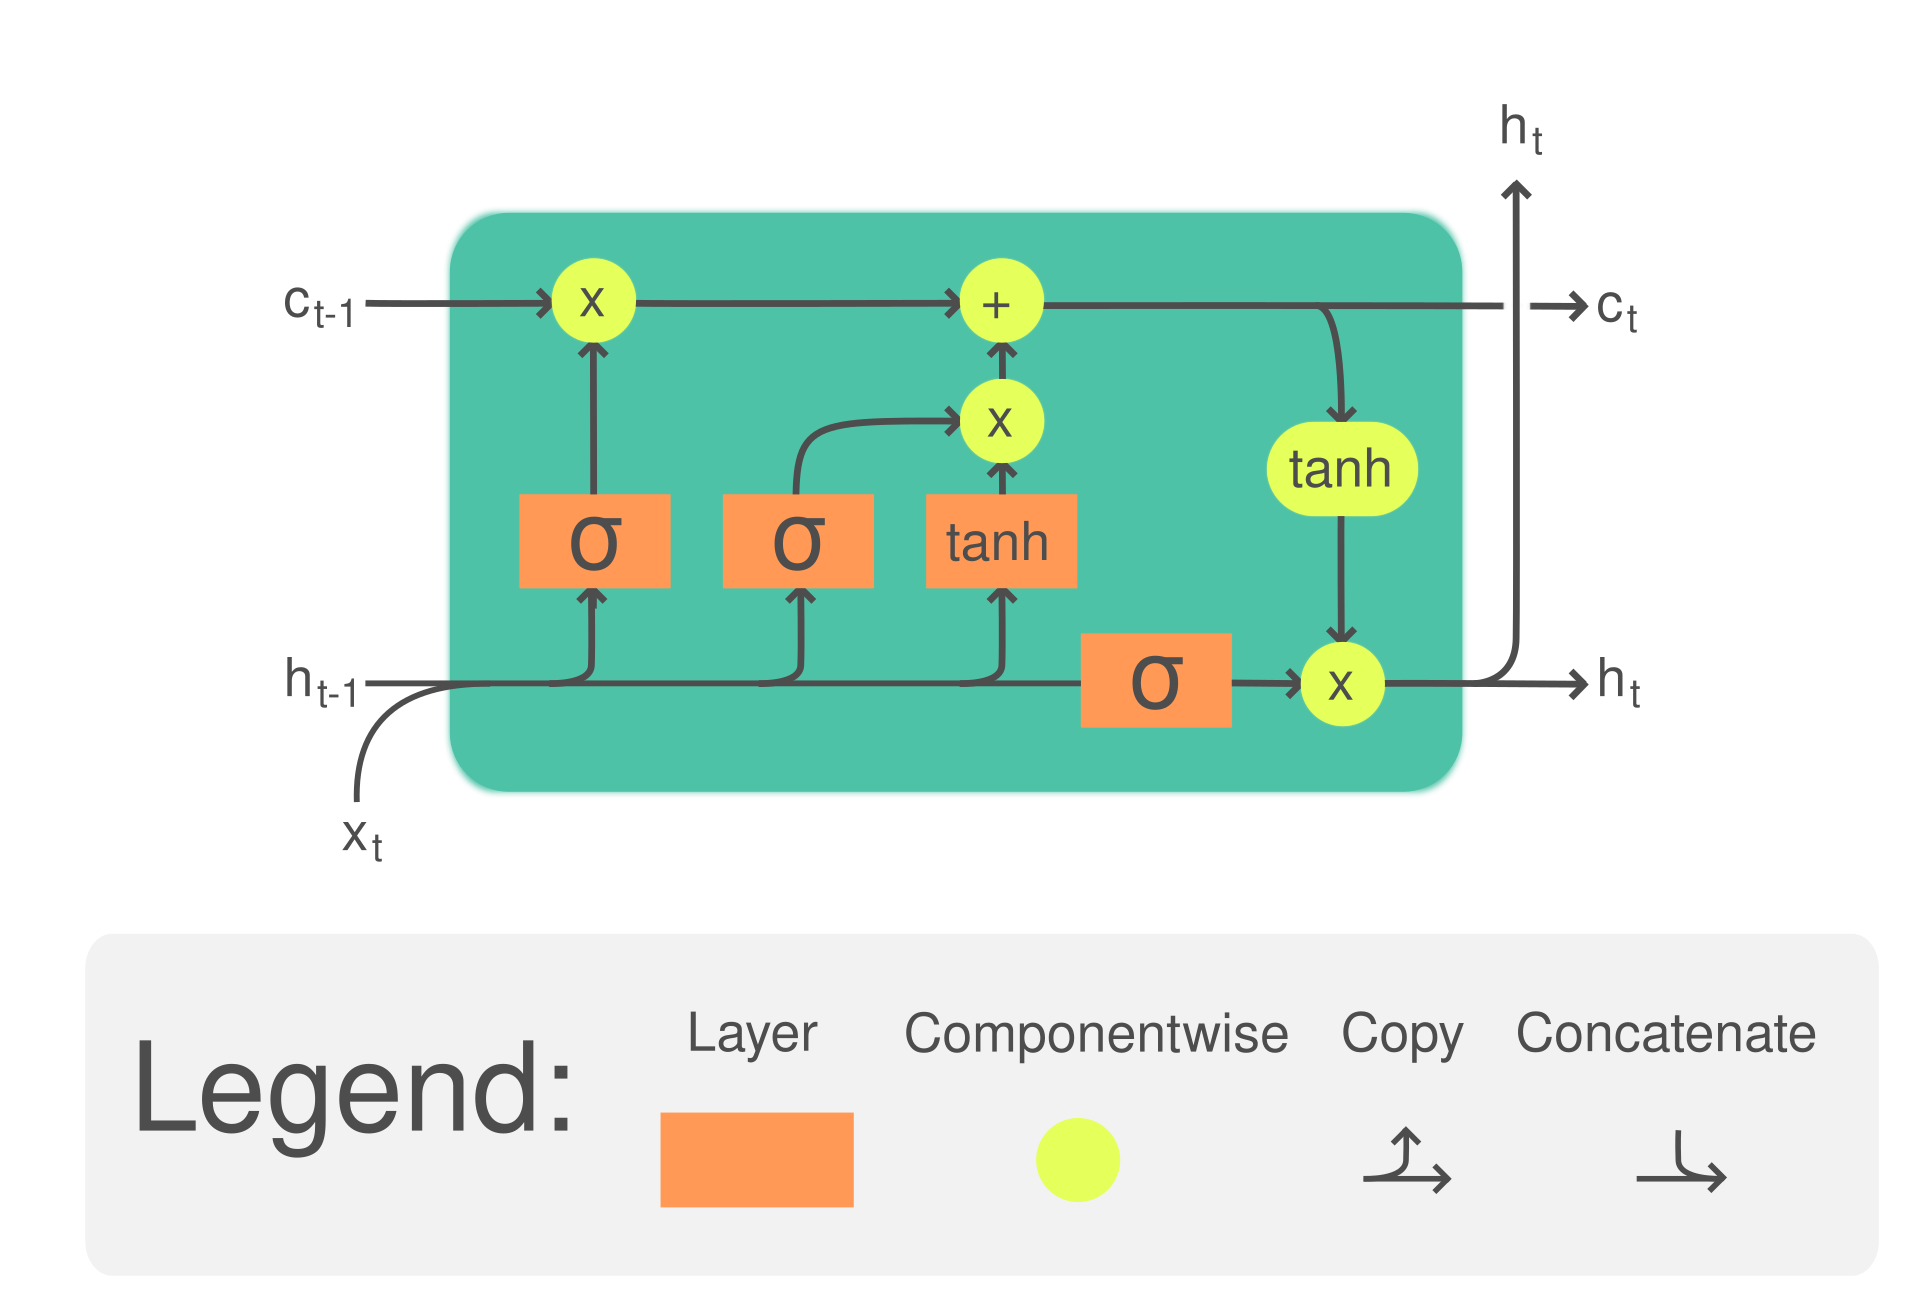

In [15]:
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM gates
        self.forget_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.input_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.cell_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.output_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

        # Final output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Activations
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden_state=None):


        batch_size, seq_len, input_dim = x.size()
        h_t, c_t = (torch.zeros(batch_size, self.hidden_dim, device=x.device),
                    torch.zeros(batch_size, self.hidden_dim, device=x.device)) if hidden_state is None else hidden_state

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat((x_t, h_t), dim=1)

            # Gates
            f_t = self.sigmoid(self.forget_gate(combined))
            i_t = self.sigmoid(self.input_gate(combined))
            g_t = self.tanh(self.cell_gate(combined))
            o_t = self.sigmoid(self.output_gate(combined))

            # Update cell state and hidden state
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * self.tanh(c_t)

            outputs.append(h_t)

        outputs = torch.stack(outputs, dim=1)
        outputs = self.fc(outputs)
        return outputs

In [16]:
model = CustomLSTM(seq_len,32,1)
loss_fn = nn.L1Loss()

In [17]:
def traning_model(model,data):
    x,y = data
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    epochs = 5000
    running_loss = 0
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs= model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 ==0 :
            print(f"running loss : {running_loss} and loss : {loss}")
            running_loss = 0.

In [18]:
traning_model(model,data=(x_train,y_train))
outputs = model(x_train)

NameError: name 'x_train' is not defined

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(outputs.view(-1).tolist(),color="grey")
plt.plot(y_train.view(-1),color="red")

In [ ]:
def stock_data(stock,no_of_days):
    import datetime as dt
    import yfinance as yf
    company =stock
    days_back = dt.timedelta(days=no_of_days)
    end = dt.date.today()
    start = end-days_back
    
    data = yf.download(company, start, end)
    return data
data = stock_data("RELIANCE.NS",32)

In [ ]:
data_formated = data[data.columns[1]].values.tolist()
c = Scaling(data_formated)
normalized_data = c.Normalization()
x_train,y_train,rest = get_batch(batch_size=5,seq_len=3,split=normalized_data)
model = CustomLSTM(3,32,1)

In [ ]:
traning_model(model,data=(x_train,y_train))

In [ ]:
outputs = model.forward(x_train)
plt.figure(figsize=(11,5))
plt.plot(outputs.view(-1).tolist(),color="grey")
plt.plot(y_train.view(-1),color="red")

In [ ]:
x,y = rest
plt.plot(model(x.unsqueeze(0)).view(-1).tolist(),color="red")
plt.plot(y.view(-1).tolist(),color="yellow")

In [ ]:
c.Normalization(denormalize=model(x.unsqueeze(0)))

In [ ]:
c.Normalization(denormalize=y)

In [ ]:
todays_prediction =torch.tensor(c.Normalization(normalization=data_formated[-seq_len:]))

prediction = c.Normalization(denormalize=model(todays_prediction.view(1,1,-1)).item())
prediction
